This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

By Weiwei Zhan & Francesco Immorlano

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [6]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [7]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data



This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [8]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


The predictand tas is **2-D** map - this point is different from the NN case

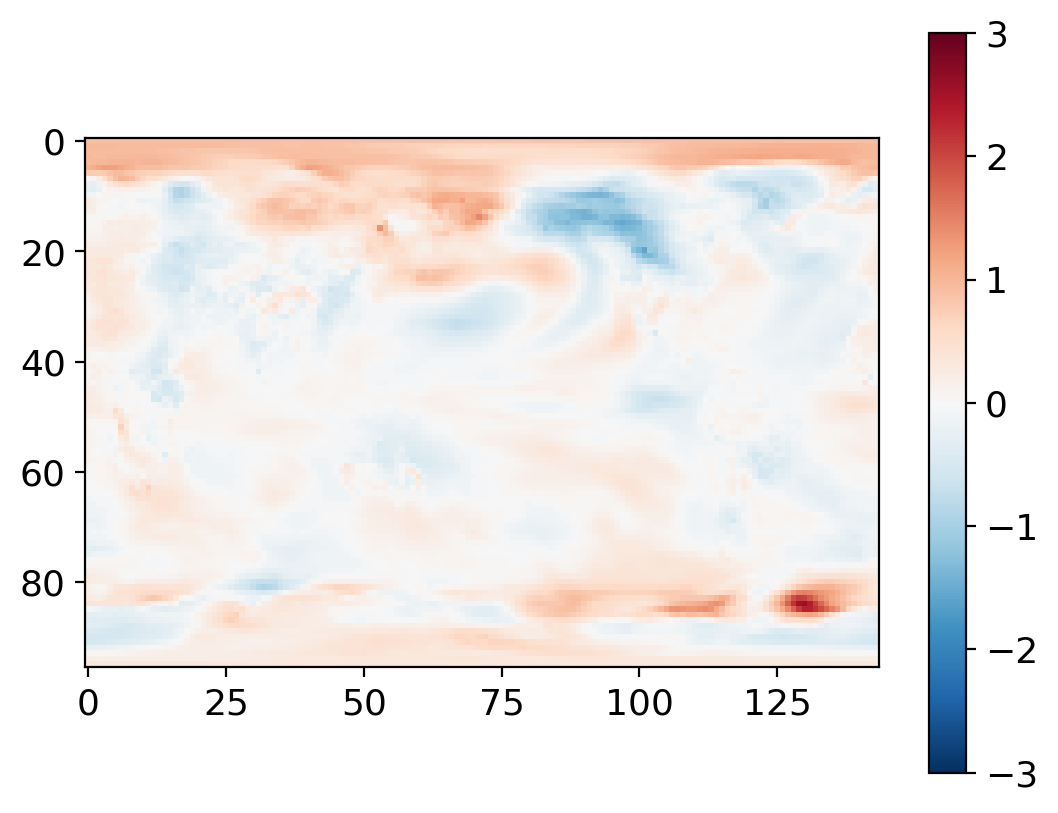

In [9]:
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar()

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [10]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(753, 2) (753, 96, 144) (86, 2) (86, 96, 144)


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

![CNN_structure](https://drive.google.com/uc?export=view&id=18a4aKFf62qWgFZP57HloHKrzHdZpmqjO)

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [12]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100


In [13]:
model = Sequential()

model.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6912)              20736     
                                                                 
 reshape (Reshape)           (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 36, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 72, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 144, 32)      16416     
 ranspose)                                                       
                                                        

### 3. Train & save the CNN model

In [14]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/100
10/10 [==============================] - 12s 1s/step - loss: 3.6997 - val_loss: 0.5288
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 2.8053 - val_loss: 2.0223
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 1.5093 - val_loss: 0.9960
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 0.8259 - val_loss: 0.7503
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 0.6146 - val_loss: 0.6519
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 0.5479 - val_loss: 0.6569
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.5065 - val_loss: 0.6833
Epoch 8/100
10/10 [==============================] - 12s 1s/step - loss: 0.4792 - val_loss: 0.7018
Epoch 9/100
10/10 [==============================] - 11s 1s/step - loss: 0.4624 - val_loss: 0.6864
Epoch 10/100
10/10 [==============================] - 11s 1s/step - loss: 0.4463 - val_loss: 0.6686
Epoch 11/

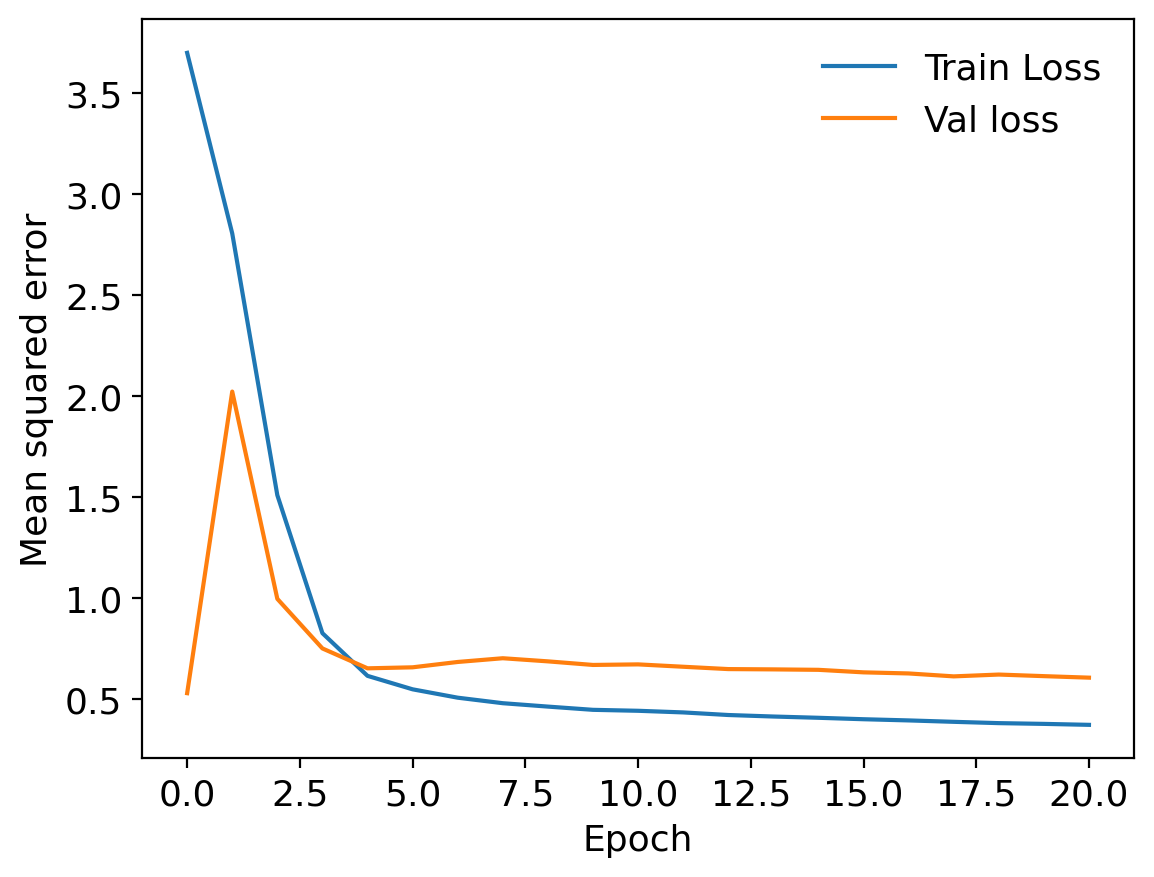

In [15]:
plot_history(history)

In [16]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [17]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'CNN_model.h5'))

### 4. Evaluate the trained model

In [18]:
# reload the saved model
model = load_model(os.path.join(model_path,'CNN_model.h5'))

In [19]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 1s 201ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

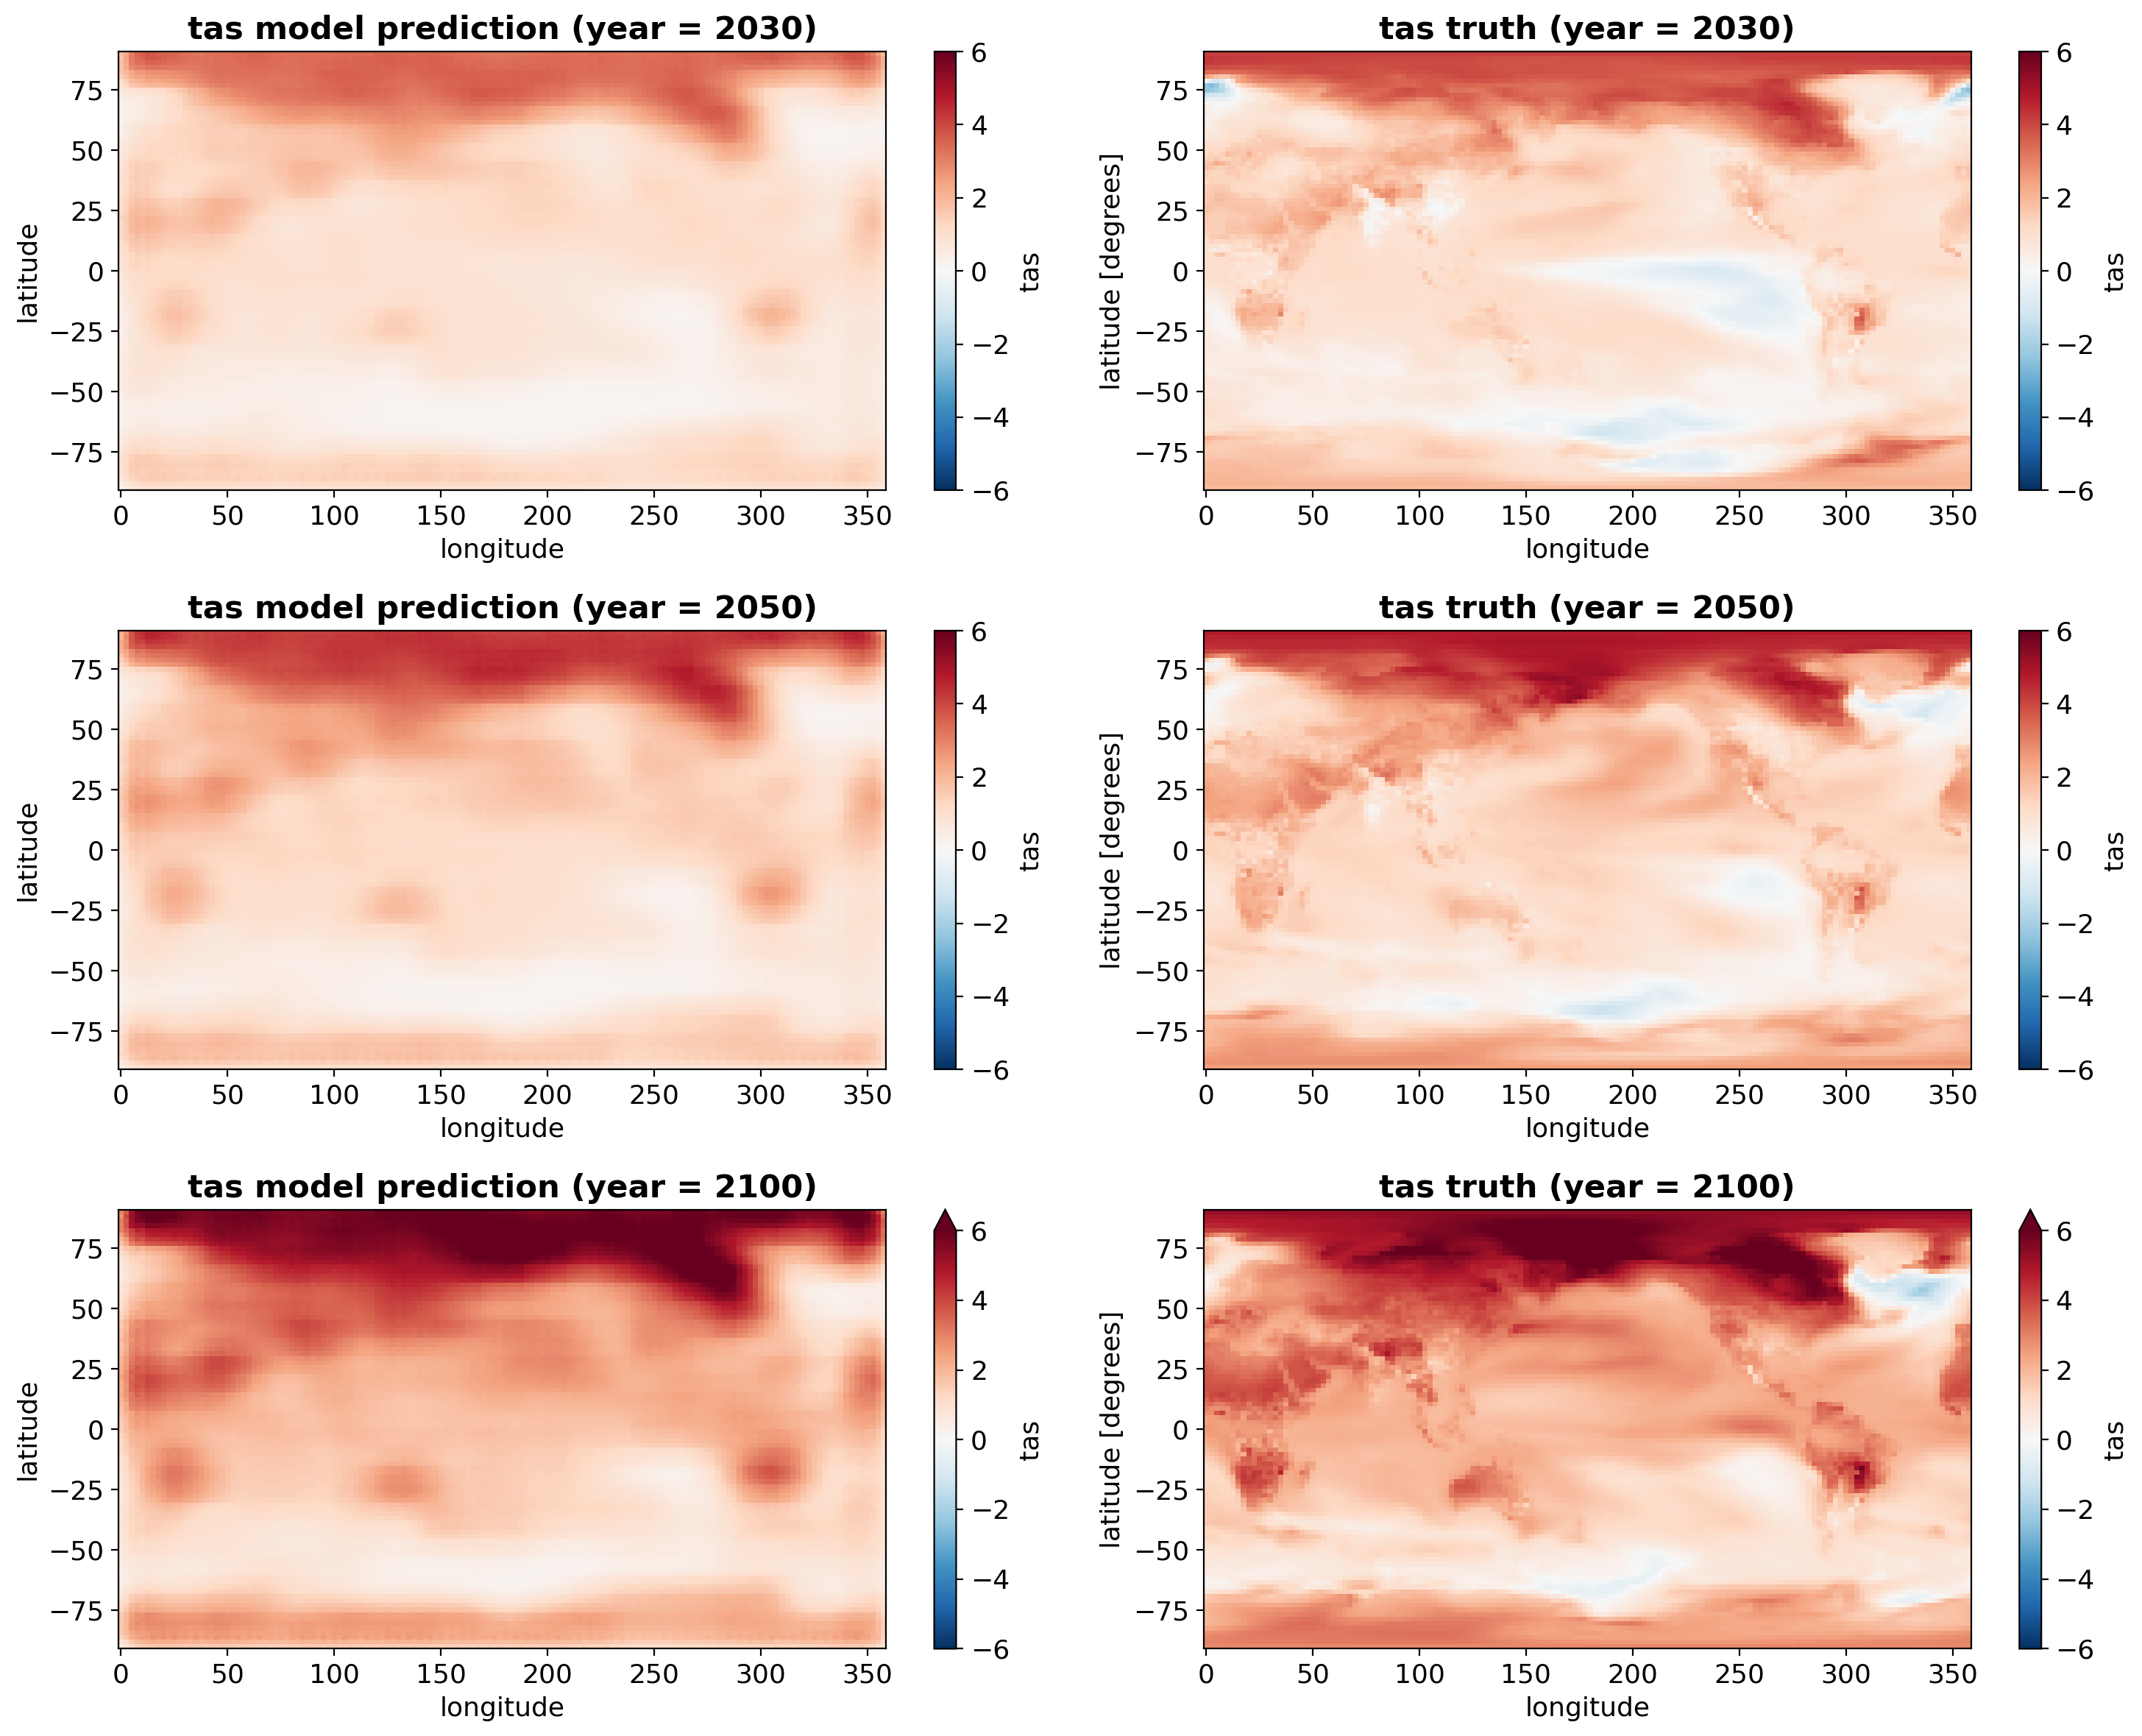

In [20]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

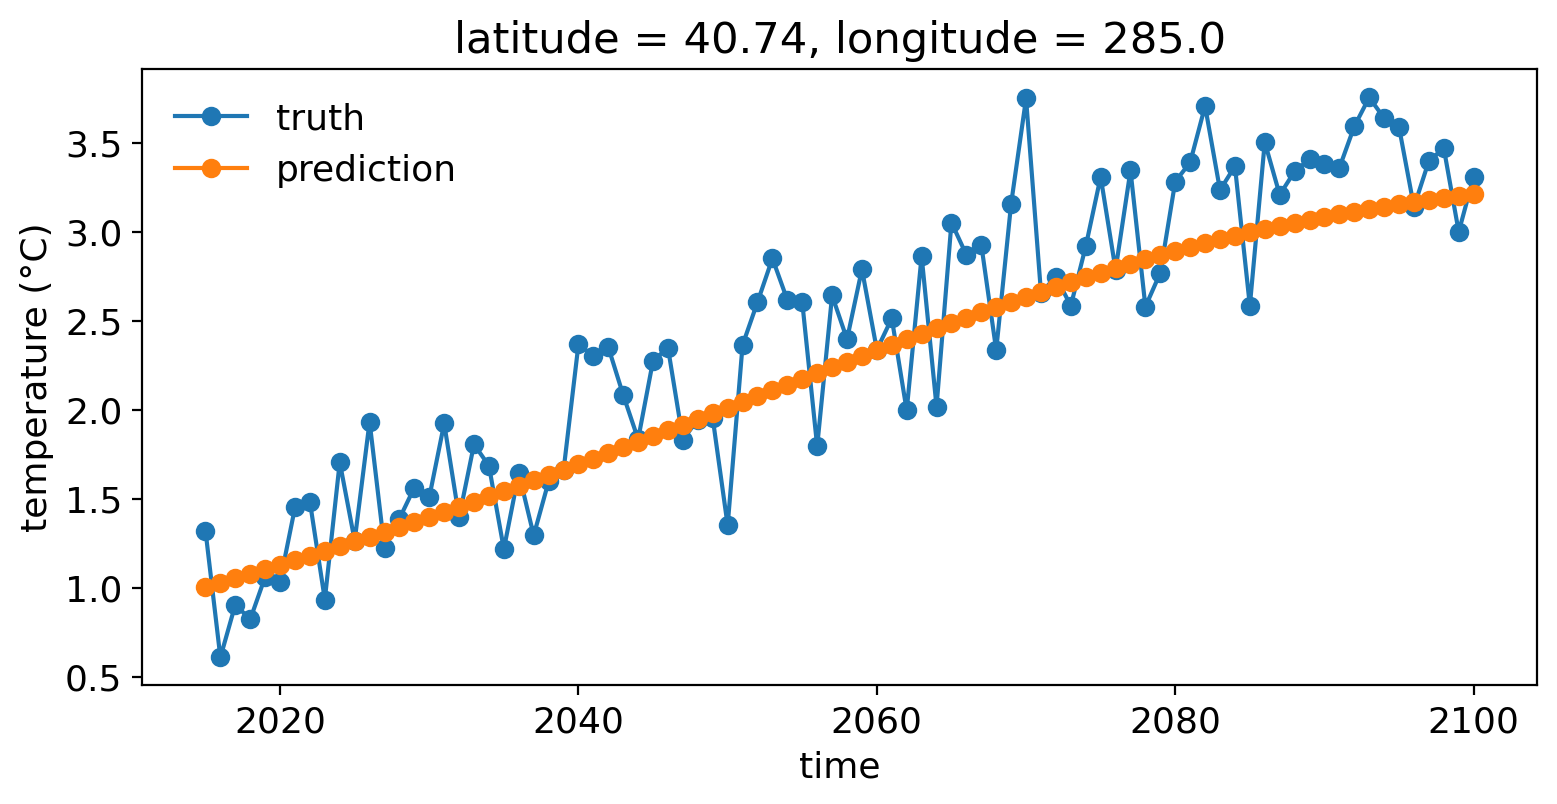

In [21]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

Finally we check whether the ML model can capture the time series of global average temperature 

In [22]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

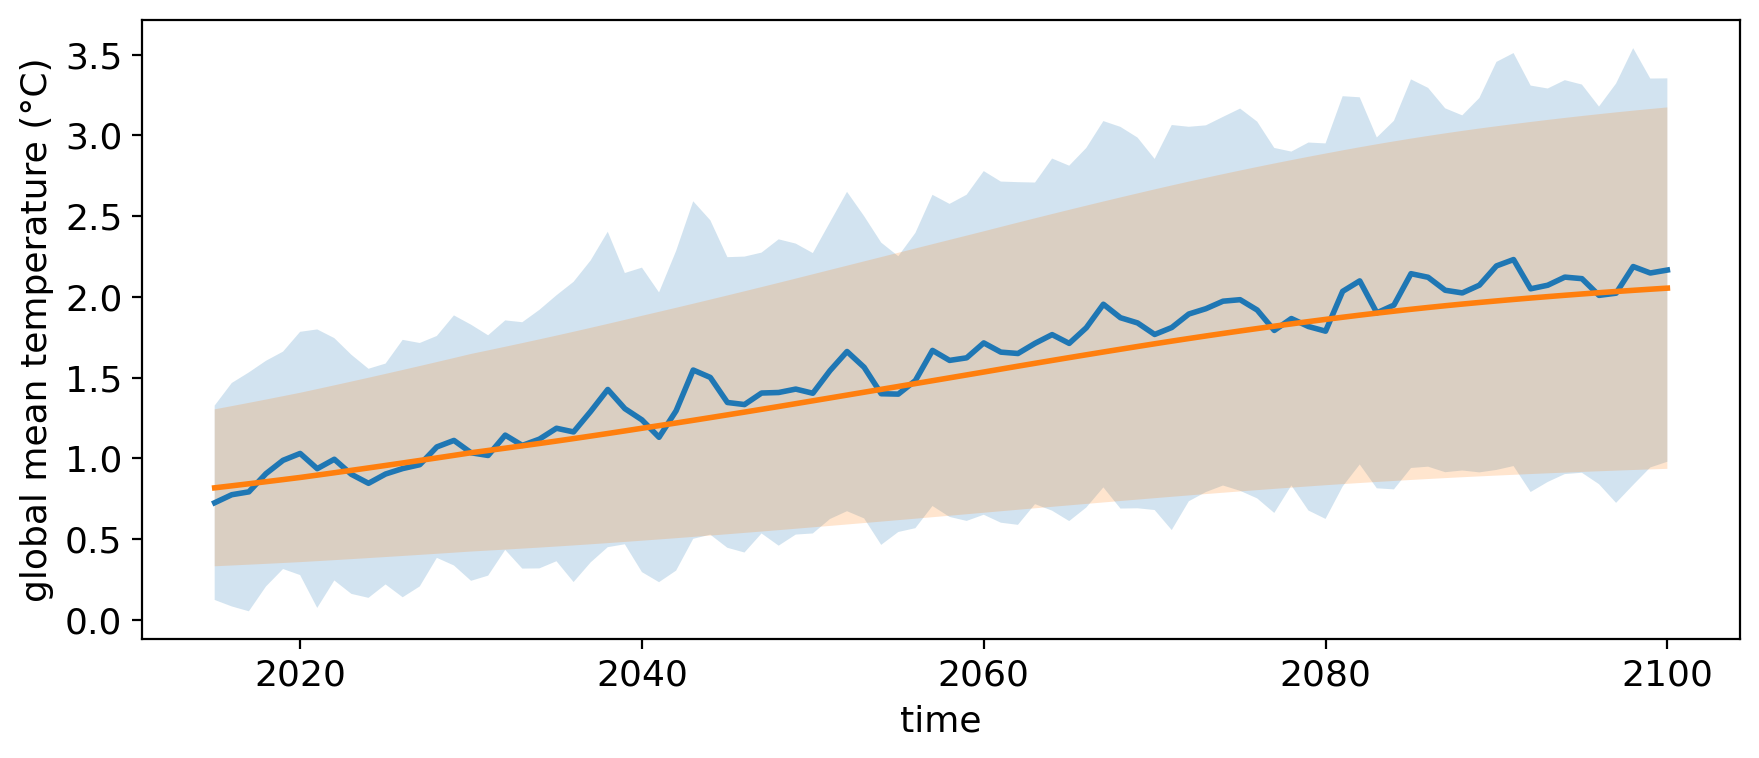

In [23]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
plt.tight_layout()